In [1]:
# imports
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import sdeint
import seaborn as sns
import IPython
import IPython.display
from numpy.random import choice
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional

In [2]:
# for the simulation of local martingale process
def sigma(x,gamma1):
    return 0.15*(x**gamma1)

# time-varying markov transition matrix, makes it super high so the chance of moving between regimes is low, can change
def markov():
    a = np.random.uniform(0.999,1)
    return([[a,1-a],[1-a,a]])
print(markov())
m = markov()

[[0.9994661537061541, 0.0005338462938458965], [0.0005338462938458965, 0.9994661537061541]]


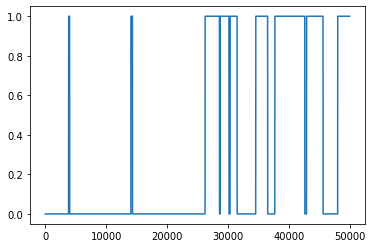

In [3]:
# simulates the SDE, provides the times where the bubble is present
n = 50000
sde = []
state = 0
for i in range(n+1):
    a = np.random.uniform(0,1)
    m = markov()
    if a > m[state][state]:
        sde.append(1-state)
        state = 1-state
    else:
        sde.append(state)
plt.plot(sde)

In [6]:
# no drift martingale
def f(x,t):
    return 0

# checks if time == 0, then bam 
def g(x,t):
    if t*n < n and sde[int(t*n)] == 0:
        return sigma(x, 0.6)
    else:
        return sigma(x, 1.3)

tspan = np.linspace(0,5.0,n+1)
result = sdeint.itoint(f,g,100,tspan)/100
print(result)

[[1.        ]
 [1.00011101]
 [0.99970028]
 ...
 [0.36725856]
 [0.36541849]
 [0.36473269]]


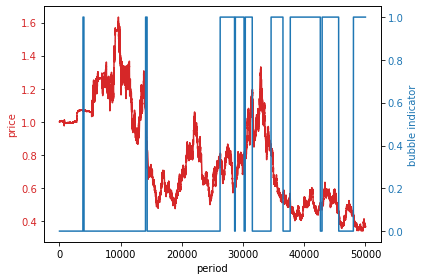

In [7]:
fig, ax1 = plt.subplots()

t = np.arange(0, n+1, 1)
color = 'tab:red'
ax1.set_xlabel('period')
ax1.set_ylabel('price', color=color)
ax1.plot(t, result, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bubble indicator', color=color)  # we already handled the x-label with ax1
ax2.plot(t, sde, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [8]:
df = pd.DataFrame(data = sde, columns = ['bbl'])
df['prc'] = result

In [9]:
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)
 
# define input and output sequence
# choose a number of time steps
seq = df['prc'].to_numpy()
s2 = df['bbl'].to_numpy()
n_steps = 10

# normalizes data, splits sequence into samples
seq = (seq - np.mean(seq))/ np.std(seq)
X = split_sequence(seq,n_steps)
X2 = seq

y = s2[0:n-9]
y2 = s2
n_features = 1

In [10]:
model = Sequential()
model.add(LSTM(50,input_shape = (n_steps,n_features)))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
model2 = Sequential()
model2.add(LSTM(50,input_shape = (1,n_features)))
model2.add(Dense(1,activation = 'sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [11]:
X = X.reshape((X.shape[0],X.shape[1],n_features))
X2 = X2.reshape((X2.shape[0],1,n_features))
s2 = df['bbl'].to_numpy()
y = s2[0:n-9]
n_train = int(n*0.8)
train_X = X[:n_train,:]
test_X = X[n_train:]
train_y = y[:n_train]
test_y = y[n_train:]
train_X2 = X2[:n_train,:]
test_X2 = X2[n_train:]
train_y2 = y2[:n_train]
test_y2 = y2[n_train:]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape)


(40000, 10, 1) (40000,) (9991, 10, 1) (9991,)
(40000, 1, 1) (40000,) (10001, 1, 1) (10001,)


Epoch 1/100
1250/1250 - 3s - loss: 0.3655 - accuracy: 0.8826 - val_loss: 0.5885 - val_accuracy: 0.7306
Epoch 2/100
1250/1250 - 3s - loss: 0.3728 - accuracy: 0.8281 - val_loss: 0.5887 - val_accuracy: 0.7306
Epoch 3/100
1250/1250 - 4s - loss: 0.3246 - accuracy: 0.8823 - val_loss: 0.6193 - val_accuracy: 0.7306
Epoch 4/100
1250/1250 - 4s - loss: 0.3703 - accuracy: 0.8531 - val_loss: 0.5921 - val_accuracy: 0.7306
Epoch 5/100
1250/1250 - 3s - loss: 0.3958 - accuracy: 0.8280 - val_loss: 0.5896 - val_accuracy: 0.7306
Epoch 6/100
1250/1250 - 4s - loss: 0.3961 - accuracy: 0.8255 - val_loss: 0.6823 - val_accuracy: 0.7306
Epoch 7/100
1250/1250 - 4s - loss: 0.3846 - accuracy: 0.8493 - val_loss: 0.5905 - val_accuracy: 0.7306
Epoch 8/100
1250/1250 - 4s - loss: 0.4219 - accuracy: 0.7965 - val_loss: 0.5904 - val_accuracy: 0.7306
Epoch 9/100
1250/1250 - 4s - loss: 0.3962 - accuracy: 0.8263 - val_loss: 0.5897 - val_accuracy: 0.7306
Epoch 10/100
1250/1250 - 4s - loss: 0.4041 - accuracy: 0.8109 - val_loss:

Epoch 80/100
1250/1250 - 4s - loss: 0.3919 - accuracy: 0.8190 - val_loss: 0.9106 - val_accuracy: 0.7306
Epoch 81/100
1250/1250 - 4s - loss: 0.3688 - accuracy: 0.8341 - val_loss: 2.2265 - val_accuracy: 0.7306
Epoch 82/100
1250/1250 - 4s - loss: 0.3754 - accuracy: 0.8304 - val_loss: 0.7825 - val_accuracy: 0.7306
Epoch 83/100
1250/1250 - 4s - loss: 0.3800 - accuracy: 0.8289 - val_loss: 1.4342 - val_accuracy: 0.7306
Epoch 84/100
1250/1250 - 4s - loss: 0.3796 - accuracy: 0.8325 - val_loss: 1.3926 - val_accuracy: 0.7306
Epoch 85/100
1250/1250 - 4s - loss: 0.3572 - accuracy: 0.8616 - val_loss: 2.1680 - val_accuracy: 0.5769
Epoch 86/100
1250/1250 - 4s - loss: 0.3702 - accuracy: 0.8277 - val_loss: 1.4383 - val_accuracy: 0.7306
Epoch 87/100
1250/1250 - 4s - loss: 0.3892 - accuracy: 0.8250 - val_loss: 2.1192 - val_accuracy: 0.5189
Epoch 88/100
1250/1250 - 4s - loss: 0.3745 - accuracy: 0.8281 - val_loss: 2.1765 - val_accuracy: 0.4552
Epoch 89/100
1250/1250 - 4s - loss: 0.3697 - accuracy: 0.8306 - 

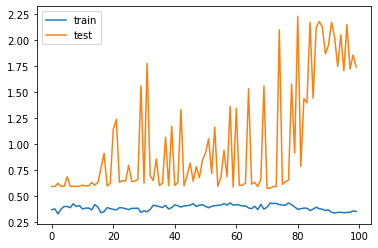

In [12]:
history_ts = model.fit(train_X,train_y, epochs = 100, batch_size = 32, validation_data=(test_X,test_y), verbose = 2, shuffle = False)
plt.plot(history_ts.history['loss'],label = 'train')
plt.plot(history_ts.history['val_loss'],label = 'test')
plt.legend()
plt.show()

Epoch 1/100
1250/1250 - 1s - loss: 0.3876 - accuracy: 0.8234 - val_loss: 0.7990 - val_accuracy: 0.7308
Epoch 2/100
1250/1250 - 1s - loss: 0.4045 - accuracy: 0.8153 - val_loss: 0.7976 - val_accuracy: 0.7308
Epoch 3/100
1250/1250 - 1s - loss: 0.4030 - accuracy: 0.8150 - val_loss: 0.7984 - val_accuracy: 0.7308
Epoch 4/100
1250/1250 - 1s - loss: 0.4025 - accuracy: 0.8156 - val_loss: 0.7984 - val_accuracy: 0.7308
Epoch 5/100
1250/1250 - 1s - loss: 0.4019 - accuracy: 0.8160 - val_loss: 0.8005 - val_accuracy: 0.7308
Epoch 6/100
1250/1250 - 1s - loss: 0.4020 - accuracy: 0.8159 - val_loss: 0.8024 - val_accuracy: 0.7308
Epoch 7/100
1250/1250 - 1s - loss: 0.4022 - accuracy: 0.8154 - val_loss: 0.8045 - val_accuracy: 0.7308
Epoch 8/100
1250/1250 - 1s - loss: 0.4026 - accuracy: 0.8152 - val_loss: 0.8066 - val_accuracy: 0.7308
Epoch 9/100
1250/1250 - 1s - loss: 0.4030 - accuracy: 0.8147 - val_loss: 0.8088 - val_accuracy: 0.7308
Epoch 10/100
1250/1250 - 1s - loss: 0.4029 - accuracy: 0.8152 - val_loss:

Epoch 80/100
1250/1250 - 1s - loss: 0.4054 - accuracy: 0.8108 - val_loss: 0.8627 - val_accuracy: 0.7308
Epoch 81/100
1250/1250 - 1s - loss: 0.4059 - accuracy: 0.8104 - val_loss: 0.8632 - val_accuracy: 0.7308
Epoch 82/100
1250/1250 - 1s - loss: 0.4051 - accuracy: 0.8118 - val_loss: 0.8606 - val_accuracy: 0.7308
Epoch 83/100
1250/1250 - 1s - loss: 0.4041 - accuracy: 0.8116 - val_loss: 0.8612 - val_accuracy: 0.7308
Epoch 84/100
1250/1250 - 1s - loss: 0.4038 - accuracy: 0.8124 - val_loss: 0.8593 - val_accuracy: 0.7308
Epoch 85/100
1250/1250 - 1s - loss: 0.4030 - accuracy: 0.8124 - val_loss: 0.8600 - val_accuracy: 0.7308
Epoch 86/100
1250/1250 - 1s - loss: 0.4027 - accuracy: 0.8126 - val_loss: 0.8603 - val_accuracy: 0.7308
Epoch 87/100
1250/1250 - 1s - loss: 0.4028 - accuracy: 0.8131 - val_loss: 0.8601 - val_accuracy: 0.7308
Epoch 88/100
1250/1250 - 1s - loss: 0.4020 - accuracy: 0.8133 - val_loss: 0.8608 - val_accuracy: 0.7308
Epoch 89/100
1250/1250 - 1s - loss: 0.4031 - accuracy: 0.8122 - 

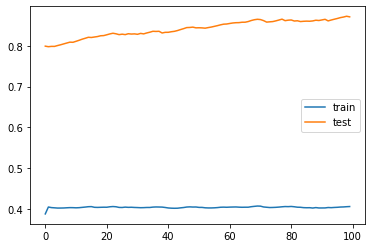

In [28]:
history_1s = model2.fit(train_X2,train_y2, epochs = 100, batch_size = 32, validation_data = (test_X2,test_y2),verbose = 2, shuffle = False)
plt.plot(history_1s.history['loss'],label = 'train')
plt.plot(history_1s.history['val_loss'],label = 'test')
plt.legend()
plt.show()

In [29]:
model3 = Sequential()
model3.add(LSTM(50,return_sequences = True, input_shape = (1,n_features)))
model3.add(Bidirectional(LSTM(50,return_sequences=True,input_shape=(n_steps,n_features))))
model3.add(Dense(1,activation = 'sigmoid'))
model3.compile(loss='binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history_3m = model3.fit(train_X2,train_y2, epochs = 200, batch_size = 32, validation_data = (test_X2,test_y2),verbose = 2, shuffle = False)


Epoch 1/200
1250/1250 - 3s - loss: 0.4097 - accuracy: 0.7958 - val_loss: 0.6322 - val_accuracy: 0.7308
Epoch 2/200
1250/1250 - 2s - loss: 0.3979 - accuracy: 0.8247 - val_loss: 0.6133 - val_accuracy: 0.7308
Epoch 3/200
1250/1250 - 2s - loss: 0.3948 - accuracy: 0.8360 - val_loss: 0.6082 - val_accuracy: 0.7308
Epoch 4/200
1250/1250 - 2s - loss: 0.3952 - accuracy: 0.8249 - val_loss: 0.6071 - val_accuracy: 0.7308
Epoch 5/200
1250/1250 - 2s - loss: 0.3953 - accuracy: 0.8289 - val_loss: 0.6042 - val_accuracy: 0.7308
Epoch 6/200
1250/1250 - 2s - loss: 0.3964 - accuracy: 0.8224 - val_loss: 0.6035 - val_accuracy: 0.7308
Epoch 7/200
1250/1250 - 2s - loss: 0.3981 - accuracy: 0.8177 - val_loss: 0.6024 - val_accuracy: 0.7308
Epoch 8/200
1250/1250 - 2s - loss: 0.4024 - accuracy: 0.8174 - val_loss: 0.5967 - val_accuracy: 0.7308
Epoch 9/200
1250/1250 - 2s - loss: 0.4032 - accuracy: 0.8040 - val_loss: 0.5991 - val_accuracy: 0.7308
Epoch 10/200
1250/1250 - 2s - loss: 0.4005 - accuracy: 0.8079 - val_loss:

Epoch 80/200
1250/1250 - 2s - loss: 0.3598 - accuracy: 0.8519 - val_loss: 1.7250 - val_accuracy: 0.5237
Epoch 81/200
1250/1250 - 2s - loss: 0.3459 - accuracy: 0.8581 - val_loss: 1.8977 - val_accuracy: 0.4934
Epoch 82/200
1250/1250 - 2s - loss: 0.3327 - accuracy: 0.8670 - val_loss: 2.0407 - val_accuracy: 0.5367
Epoch 83/200
1250/1250 - 2s - loss: 0.3461 - accuracy: 0.8584 - val_loss: 1.8918 - val_accuracy: 0.5192
Epoch 84/200
1250/1250 - 2s - loss: 0.3393 - accuracy: 0.8587 - val_loss: 1.9636 - val_accuracy: 0.5229
Epoch 85/200
1250/1250 - 2s - loss: 0.3167 - accuracy: 0.8781 - val_loss: 2.1781 - val_accuracy: 0.5393
Epoch 86/200
1250/1250 - 2s - loss: 0.3261 - accuracy: 0.8695 - val_loss: 2.2125 - val_accuracy: 0.5062
Epoch 87/200
1250/1250 - 2s - loss: 0.3162 - accuracy: 0.8788 - val_loss: 2.4868 - val_accuracy: 0.5073
Epoch 88/200
1250/1250 - 2s - loss: 0.3302 - accuracy: 0.8630 - val_loss: 2.3326 - val_accuracy: 0.5219
Epoch 89/200
1250/1250 - 2s - loss: 0.3114 - accuracy: 0.8780 - 

Epoch 159/200
1250/1250 - 2s - loss: 0.3031 - accuracy: 0.8796 - val_loss: 2.9174 - val_accuracy: 0.5412
Epoch 160/200
1250/1250 - 2s - loss: 0.3173 - accuracy: 0.8770 - val_loss: 3.0516 - val_accuracy: 0.5204
Epoch 161/200
1250/1250 - 2s - loss: 0.3276 - accuracy: 0.8686 - val_loss: 3.0117 - val_accuracy: 0.5178
Epoch 162/200
1250/1250 - 2s - loss: 0.3038 - accuracy: 0.8856 - val_loss: 3.0817 - val_accuracy: 0.5897
Epoch 163/200
1250/1250 - 2s - loss: 0.3249 - accuracy: 0.8727 - val_loss: 2.9883 - val_accuracy: 0.5145
Epoch 164/200
1250/1250 - 2s - loss: 0.3121 - accuracy: 0.8787 - val_loss: 3.0679 - val_accuracy: 0.5246
Epoch 165/200
1250/1250 - 2s - loss: 0.3223 - accuracy: 0.8808 - val_loss: 2.9503 - val_accuracy: 0.5424
Epoch 166/200
1250/1250 - 2s - loss: 0.3303 - accuracy: 0.8687 - val_loss: 2.9365 - val_accuracy: 0.5030
Epoch 167/200
1250/1250 - 2s - loss: 0.3057 - accuracy: 0.8808 - val_loss: 2.8499 - val_accuracy: 0.5635
Epoch 168/200
1250/1250 - 2s - loss: 0.3219 - accuracy:

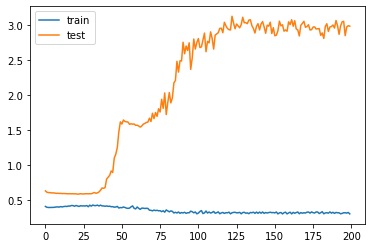

In [31]:
plt.plot(history_3m.history['loss'],label = 'train')
plt.plot(history_3m.history['val_loss'],label = 'test')
plt.legend()
plt.show()

0         2006-01-03
1         2006-01-04
2         2006-01-05
3         2006-01-06
4         2006-01-09
             ...    
991369    2013-12-24
991370    2013-12-26
991371    2013-12-27
991372    2013-12-30
991373    2013-12-31
Name: date, Length: 991374, dtype: object


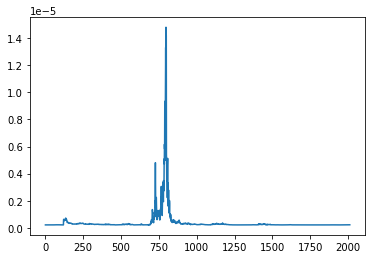

In [32]:
df = pd.read_csv('cbcbcfc32b6eee39 (1).txt',sep='\t')
df['date'] = pd.to_datetime(df['date'],format ='%Y%m%d').dt.date
print(df['date'])
df_msft = df[df['TICKER'] == 'TROW']
df_msft.head()
X = df_msft['PRC'].values
X_seq = split_sequence(X,n_steps)
X = X.reshape(X.shape[0],1,1)
bubbles_msft2 = model2.predict(X)
bubbles_msft3 = model3.predict(X)
bubbles_msft3 = bubbles_msft3.flatten()
X_seq = X_seq.reshape(X_seq.shape[0],n_steps,1)
bubbles_msft1 = model.predict(X_seq)
plt.plot(bubbles_msft3)


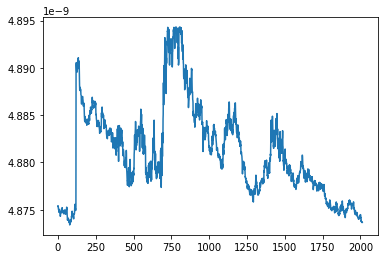

In [33]:
plt.plot(bubbles_msft2)

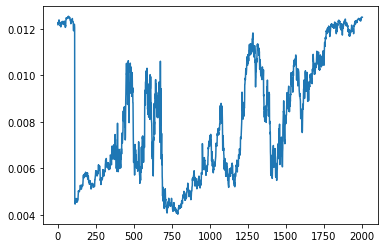

In [34]:
dates = df_msft['date'].values
plt.plot(bubbles_msft1)

In [70]:
# model 1

bbl_dates = []
row_indices = []
if bubbles_msft1[0] > 0.012:
    bbl = True
    bbl_dates.append(dates[0])
    row_indices.append(0)
else:
    bbl = False
for i in range(2003):
    if bbl == True and bubbles_msft1[i] < 0.011:
        bbl_dates.append(dates[i])
        row_indices.append(i)
        bbl = False
    if bbl == False and bubbles_msft1[i] > 0.011:
        bbl_dates.append(dates[i])
        row_indices.append(i)
        bbl = True

if len(bbl_dates)%2 == 1:
    row_indices.append(2002)
    bbl_dates.append(dates[-1])

bbl_dates = np.reshape(bbl_dates,(len(bbl_dates)//2,2))
row_indices = np.reshape(row_indices,(len(row_indices)//2,2))
print(row_indices)
print(bbl_dates)

[[   0  111]
 [1257 1261]
 [1263 1268]
 [1270 1272]
 [1274 1289]
 [1291 1293]
 [1294 1296]
 [1311 1323]
 [1325 1326]
 [1703 1704]
 [1714 1715]
 [1745 1746]
 [1752 2002]]
[[datetime.date(2006, 1, 3) datetime.date(2006, 6, 13)]
 [datetime.date(2010, 12, 30) datetime.date(2011, 1, 5)]
 [datetime.date(2011, 1, 7) datetime.date(2011, 1, 14)]
 [datetime.date(2011, 1, 19) datetime.date(2011, 1, 21)]
 [datetime.date(2011, 1, 25) datetime.date(2011, 2, 15)]
 [datetime.date(2011, 2, 17) datetime.date(2011, 2, 22)]
 [datetime.date(2011, 2, 23) datetime.date(2011, 2, 25)]
 [datetime.date(2011, 3, 18) datetime.date(2011, 4, 5)]
 [datetime.date(2011, 4, 7) datetime.date(2011, 4, 8)]
 [datetime.date(2012, 10, 5) datetime.date(2012, 10, 8)]
 [datetime.date(2012, 10, 22) datetime.date(2012, 10, 23)]
 [datetime.date(2012, 12, 7) datetime.date(2012, 12, 10)]
 [datetime.date(2012, 12, 18) datetime.date(2013, 12, 31)]]


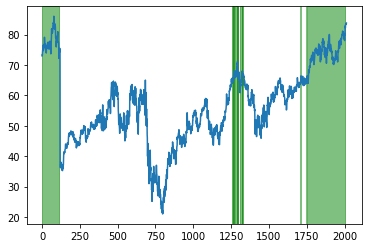

In [71]:
for i in range(len(row_indices)):
    plt.axvspan(row_indices[i][0],row_indices[i][1],color='green',alpha = 0.5)
plt.plot(X.flatten())
plt.show()

In [55]:
df_msft["id"] = df_msft.index-2013-2013
df_msft.head()


<ipython-input-55-9019740afc77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msft["id"] = df_msft.index-2013-2013


,PERMNO,date,TICKER,PRC,id
4026,10138,2006-01-03,TROW,72.99,0
4027,10138,2006-01-04,TROW,73.32,1
4028,10138,2006-01-05,TROW,73.26,2
4029,10138,2006-01-06,TROW,73.86,3
4030,10138,2006-01-09,TROW,74.86,4


In [66]:
# results from psymonitor package

bbl_dates_psy = [[pd.to_datetime('20060626',format='%Y%m%d').date(),pd.to_datetime('20060627',format='%Y%m%d').date()],
                 [pd.to_datetime('20101105',format='%Y%m%d').date(),pd.to_datetime('20101105',format='%Y%m%d').date()],
                 [pd.to_datetime('20101222',format='%Y%m%d').date(),pd.to_datetime('20101222',format='%Y%m%d').date()],[pd.to_datetime('20061004',format='%Y%m%d').date(),pd.to_datetime('20061005',format='%Y%m%d').date()],
                 [pd.to_datetime('20110114',format='%Y%m%d').date(),pd.to_datetime('20110118',format='%Y%m%d').date()],
                 [pd.to_datetime('20110218',format='%Y%m%d').date(),pd.to_datetime('20110218',format='%Y%m%d').date()],[pd.to_datetime('20061004',format='%Y%m%d').date(),pd.to_datetime('20061005',format='%Y%m%d').date()],
                 [pd.to_datetime('20110808',format='%Y%m%d').date(),pd.to_datetime('20110808',format='%Y%m%d').date()],
                ]
row_indices2 = []
for i in range(len(bbl_dates_psy)):
    row_indices2.append((df_msft['id'][df_msft['date'] == bbl_dates_psy[i][0]].values[0],df_msft['id'][df_msft['date'] == bbl_dates_psy[i][1]].values[0]))
print(row_indices2)

[(120, 121), (1220, 1220), (1252, 1252), (190, 191), (1268, 1269), (1292, 1292), (190, 191), (1409, 1409)]


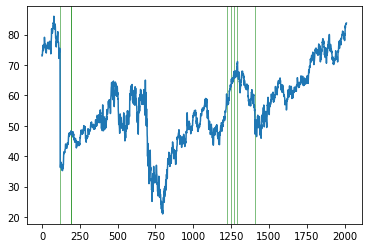

In [72]:
for i in range(len(row_indices2)):
    plt.axvspan(row_indices2[i][0],row_indices2[i][1],color='green',alpha = 0.5)
plt.plot(X.flatten())
plt.show()

In [81]:
df_msft['id'][df_msft['date'] == pd.to_datetime('20121209',format='%Y%m%d').date()]

Series([], Name: id, dtype: int64)